# Tutorial: Multiscale PDE learning with Fourier Feature Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial13/tutorial.ipynb)

This tutorial presents how to solve with Physics-Informed Neural Networks (PINNs)
a PDE characterized by multiscale behaviour, as
presented in [*On the eigenvector bias of Fourier feature networks: From regression to solving
multi-scale PDEs with physics-informed neural networks*](
https://doi.org/10.1016/j.cma.2021.113938). 

First of all, some useful imports.

In [1]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"

import torch
import matplotlib.pyplot as plt
import warnings

from pina import Condition, Trainer
from pina.problem import SpatialProblem
from pina.operator import laplacian
from pina.solver import PINN, SelfAdaptivePINN as SAPINN
from pina.model.block import FourierFeatureEmbedding
from pina.loss import LpLoss
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue
from pina.model import FeedForward

warnings.filterwarnings('ignore')

## Multiscale Problem

We begin by presenting the problem which also can be found in Section 2 of [*On the eigenvector bias of Fourier feature networks: From regression to solving
multi-scale PDEs with physics-informed neural networks*](
https://doi.org/10.1016/j.cma.2021.113938). The one-dimensional Poisson problem we aim to solve is mathematically written as:

\begin{equation}
\begin{cases}
\Delta u (x) + f(x) = 0 \quad x \in [0,1], \\
u(x) = 0 \quad x \in \partial[0,1], \\
\end{cases}
\end{equation}

We impose the solution as $u(x) = \sin(2\pi x) + 0.1 \sin(50\pi x)$ and obtain the force term $f(x) = (2\pi)^2 \sin(2\pi x) + 0.1 (50 \pi)^2 \sin(50\pi x)$.
Though this example is simple and pedagogical, it is worth noting that
the solution exhibits low frequency in the macro-scale and high frequency in the micro-scale, which resembles many
practical scenarios.


In **PINA** this problem is written, as always, as a class [see here for a tutorial on the Problem class](https://mathlab.github.io/PINA/_rst/tutorials/tutorial1/tutorial.html). Below you can find the `Poisson` problem which is mathmatically described above.

In [2]:
class Poisson(SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1]})

    def poisson_equation(input_, output_):
        x = input_.extract('x')
        u_xx = laplacian(output_, input_, components=['u'], d=['x'])
        f = ((2*torch.pi)**2)*torch.sin(2*torch.pi*x) + 0.1*((50*torch.pi)**2)*torch.sin(50*torch.pi*x)
        return u_xx + f

    # here we write the problem conditions
    conditions = {
        'bound_cond0' : Condition(domain=CartesianDomain({'x': 0.}),
                             equation=FixedValue(0.)),
        'bound_cond1' : Condition(domain=CartesianDomain({'x': 1.}),
                             equation=FixedValue(0.)),
        'phys_cond':       Condition(domain=spatial_domain,
                             equation=Equation(poisson_equation)),
    }

    def truth_solution(self, x):
        return torch.sin(2*torch.pi*x) + 0.1*torch.sin(50*torch.pi*x)

problem = Poisson()

# let's discretise the domain
problem.discretise_domain(128, 'grid', domains=['phys_cond'])
problem.discretise_domain(1, 'grid', domains=['bound_cond0','bound_cond1'])

A standard PINN approach would be to fit this model using a Feed Forward (fully connected) Neural Network. For a conventional fully-connected neural network is easy to
approximate a function $u$, given sufficient data inside the computational domain. However solving high-frequency or multi-scale problems presents great challenges to PINNs especially when the number of data cannot capture the different scales.

Below we run a simulation using the `PINN` solver and the self adaptive `SAPINN` solver, using a [`FeedForward`](https://mathlab.github.io/PINA/_modules/pina/model/feed_forward.html#FeedForward) model. We used a `MultiStepLR` scheduler to decrease the learning rate slowly during training (it takes around 2 minutes to run on CPU).

In [3]:
from pina.optim import TorchScheduler

# training with PINN and visualize results
pinn = PINN(problem=problem,
            model=FeedForward(input_dimensions=1, output_dimensions=1, layers=[100, 100, 100]),
            scheduler=TorchScheduler(torch.optim.lr_scheduler.MultiStepLR,  # Pass the class directly, not an instance
                milestones=[1000,2000,3000,4000],
                gamma=0.9))

trainer = Trainer(pinn, max_epochs=5000, accelerator='cpu', enable_model_summary=False, val_size=0., train_size=1., test_size=0.)
trainer.train()

# training with PINN and visualize results
sapinn = SAPINN(problem=problem,
            model=FeedForward(input_dimensions=1, output_dimensions=1, layers=[100, 100, 100]),
            scheduler_model=TorchScheduler(torch.optim.lr_scheduler.MultiStepLR,  
                milestones=[1000,2000,3000,4000],
                gamma=0.9))
trainer_sapinn = Trainer(sapinn, max_epochs=5000, accelerator='cpu', enable_model_summary=False, val_size=0., train_size=1., test_size=0.)
trainer_sapinn.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 53.24it/s, v_num=77, bound_cond0_loss=2.57e+3, bound_cond1_loss=2.57e+3, phys_cond_loss=421.0, train_loss=5.57e+3]  

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s, v_num=77, bound_cond0_loss=2.57e+3, bound_cond1_loss=2.57e+3, phys_cond_loss=421.0, train_loss=5.57e+3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s, v_num=78, bound_cond0_loss=633.0, bound_cond1_loss=660.0, phys_cond_loss=2.57e+3, train_loss=3.86e+3]    

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s, v_num=78, bound_cond0_loss=633.0, bound_cond1_loss=660.0, phys_cond_loss=2.57e+3, train_loss=3.86e+3]


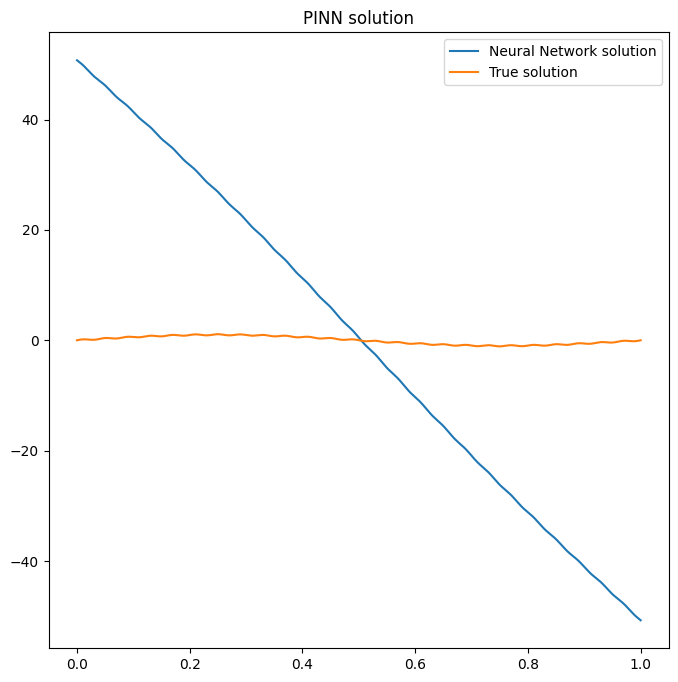

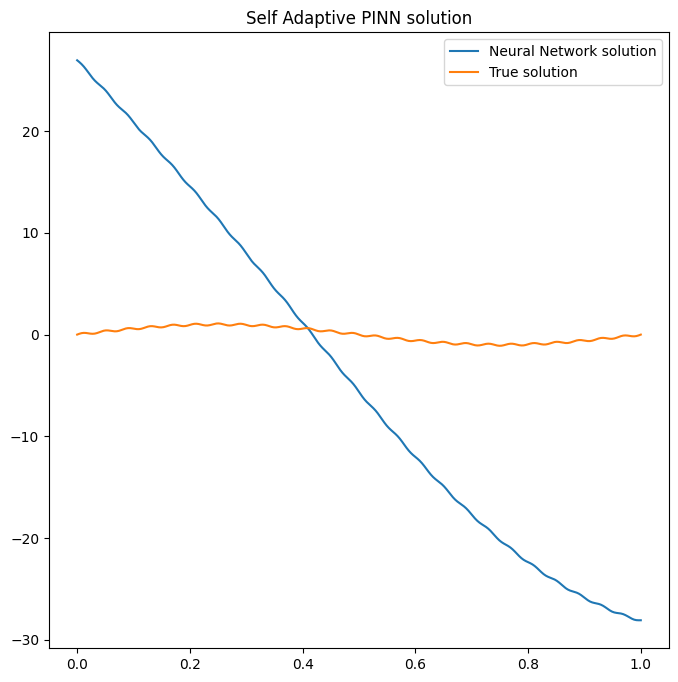

In [4]:
#define the function to plot the solution obtained using matplotlib
def plot_solution(pinn_to_use, title):
    pts = pinn_to_use.problem.spatial_domain.sample(256, 'grid', variables='x')
    predicted_output = pinn_to_use.forward(pts).extract('u').as_subclass(torch.Tensor).cpu().detach()
    true_output = pinn_to_use.problem.truth_solution(pts).cpu().detach()
    pts = pts.cpu()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.plot(pts.extract(['x']), predicted_output, label='Neural Network solution')
    ax.plot(pts.extract(['x']), true_output, label='True solution')
    plt.title(title)
    plt.legend()

#plot the solution of the two PINNs
plot_solution(pinn, 'PINN solution')
plot_solution(sapinn, 'Self Adaptive PINN solution')

We can clearly see that the solution has not been learned by the two different solvers. Indeed the big problem is not in the optimization strategy (i.e. the solver), but in the model used to solve the problem. A simple `FeedForward` network can hardly handle multiscales if not enough collocation points are used!

We can also compute the $l_2$ relative error for the `PINN` and `SAPINN` solutions:

In [5]:
# l2 loss from PINA losses
l2_loss = LpLoss(p=2, relative=True)

# sample new test points
pts = pts = problem.spatial_domain.sample(100, 'grid')
print(f'Relative l2 error PINN      {l2_loss(pinn(pts), problem.truth_solution(pts)).item():.2%}')
print(f'Relative l2 error SAPINN    {l2_loss(sapinn(pts), problem.truth_solution(pts)).item():.2%}')

Relative l2 error PINN      95.74%
Relative l2 error SAPINN    95.71%


Which is indeed very high!

## Fourier Feature Embedding in PINA

Fourier Feature Embedding is a way to transform the input features, to help the network in learning multiscale variations in the output. It was
first introduced in [*On the eigenvector bias of Fourier feature networks: From regression to solving
multi-scale PDEs with physics-informed neural networks*](
https://doi.org/10.1016/j.cma.2021.113938) showing great results for multiscale problems. The basic idea is to map the input $\mathbf{x}$ into an embedding $\tilde{\mathbf{x}}$ where:

$$ \tilde{\mathbf{x}} =\left[\cos\left( \mathbf{B} \mathbf{x} \right), \sin\left( \mathbf{B} \mathbf{x} \right)\right] $$

and $\mathbf{B}_{ij} \sim \mathcal{N}(0, \sigma^2)$. This simple operation allow the network to learn on multiple scales! 

In PINA we already have implemented the feature as a `layer` called [`FourierFeatureEmbedding`](https://mathlab.github.io/PINA/_rst/layers/fourier_embedding.html). Below we will build the *Multi-scale Fourier Feature Architecture*. In this architecture multiple Fourier feature embeddings (initialized with different $\sigma$)
are applied to input coordinates and then passed through the same fully-connected neural network, before the outputs are finally concatenated with a linear layer.

In [6]:
class MultiscaleFourierNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding1 = FourierFeatureEmbedding(input_dimension=1, 
                                                  output_dimension=100,
                                                  sigma=1)
        self.embedding2 = FourierFeatureEmbedding(input_dimension=1, 
                                                  output_dimension=100,
                                                  sigma=10)
        self.layers = FeedForward(input_dimensions=100, output_dimensions=100, layers=[100])
        self.final_layer = torch.nn.Linear(2*100, 1)

    def forward(self, x):
        e1 = self.layers(self.embedding1(x))
        e2 = self.layers(self.embedding2(x))
        return self.final_layer(torch.cat([e1, e2], dim=-1))

We will train the `MultiscaleFourierNet` with the `PINN` solver (and feel free to try also with our PINN variants (`SAPINN`, `GPINN`, `CompetitivePINN`, ...).

In [7]:
multiscale_pinn = PINN(problem=problem,
                       model=MultiscaleFourierNet(),
                       scheduler=TorchScheduler(torch.optim.lr_scheduler.MultiStepLR,  
                milestones=[1000,2000,3000,4000],
                gamma=0.9))
trainer = Trainer(multiscale_pinn, max_epochs=5000, accelerator='cpu', enable_model_summary=False, val_size=0., train_size=1., test_size=0.) # we train on CPU and avoid model summary at beginning of training (optional)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 40.89it/s, v_num=79, bound_cond0_loss=0.000113, bound_cond1_loss=0.000103, phys_cond_loss=57.90, train_loss=57.90]      

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=79, bound_cond0_loss=0.000113, bound_cond1_loss=0.000103, phys_cond_loss=57.90, train_loss=57.90]


Let us now plot the solution and compute the relative $l_2$ again!

Relative l2 error PINN with MultiscaleFourierNet:   3.52%


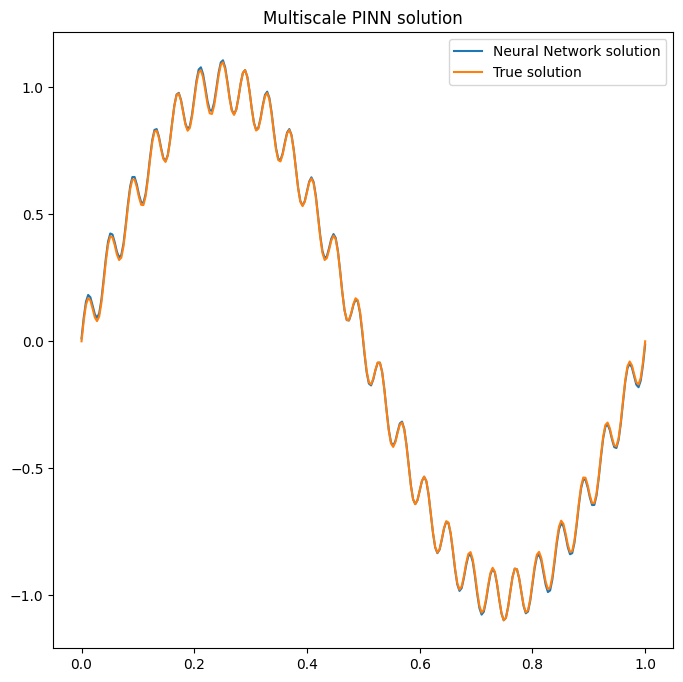

In [8]:
#plot solution obtained
plot_solution(multiscale_pinn, 'Multiscale PINN solution')

# sample new test points
pts = pts = problem.spatial_domain.sample(100, 'grid')
print(f'Relative l2 error PINN with MultiscaleFourierNet:   {l2_loss(multiscale_pinn(pts), problem.truth_solution(pts)).item():.2%}')

It is pretty clear that the network has learned the correct solution, with also a very low error. Obviously a longer training and a more expressive neural network could improve the results!

## What's next?

Congratulations on completing the one dimensional Poisson tutorial of **PINA** using `FourierFeatureEmbedding`! There are multiple directions you can go now:

1. Train the network for longer or with different layer sizes and assert the finaly accuracy

2. Understand the role of `sigma` in `FourierFeatureEmbedding` (see original paper for a nice reference)

3. Code the *Spatio-temporal multi-scale Fourier feature architecture* for a more complex time dependent PDE (section 3 of the original reference)

4. Many more...